# Matriz factorization for recommender systems

## Author: Sebastian Pineda Arango
## Organization: Hildesheim University

In this notebook, we create a recommender system using matrix factorization. With matrix factorizations, we start from a user-item matrix ($R$) and find two matrices $Q$ and $P$. This concept can be summarized in the following equation and the following image [1].

$R = PQ^T$

<img src="Factorization1.png">

The matrix $R$ contains the rating given by a user $U$ to an Item $I$. All ratings of a given user are placed in a given row. On the other hand, all ratings of a given item are placed in a given column. Therefore, the element $R_{ij}$ of the matrix $R$ is the rating of the user i to the item j. The matrix $R \space \in \space R^{n\times m}$, while the matrices $P \space \in \space R^{n \times k}$  and $Q \space \in \space R^{m \times k}$ have a new common dimension $K$, which corresponds to latent features. 

The implemented algorithm for the matrix factorization is the alternating least squares [2] which is essentially applying stochastic gradient ascent (SGD) algorithm. More information about this algorithm can be found in different sources [3][4].

Firstly, we import the data and take a look to the format.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

data = pd.read_csv("train.data")

data.head()

,planet,person,score
0,3181,1493,4
1,2686,1866,5
2,2308,3104,5
3,3779,1938,4
4,3032,3049,4


We see that the dataset has three columns. The first column is called _planet_ (user), the second column is called _person_ (item) and the third one is called _score_ (rating). This is the same matrix R (above mentioned) but is represented in a better format to save storage. 

### Train-test split

We split data in train-test to make hyperparameter tuning. We assing 80% of the data to training set and the rest to the test set.

In [12]:
data.iloc[:,1] = data.iloc[:,1]-1 #since numeration starts in 1
u, i, r = data.iloc[:,0], data.iloc[:,1], data.iloc[:,2]

n_p = np.max(u)+1
n_q = np.max(i)+1

train_pct = 0.8

###Splitting train vs test
#getting the total number of training samples
data_size = data.shape[0]
train_size = int(train_pct*data_size)

#shuffling indexes to separate train and test randoming
idx = np.arange(0,data_size)
np.random.shuffle(idx)

#creating test indexes
train_idx = idx[:train_size]

#creating test indexes
test_idx = idx[train_size:]

#selecting train data (features)
X_train = np.array(data.iloc[train_idx,])

X_test = np.array(data.iloc[test_idx,])


### Training and hyperparameter tuning

Two functions are defined:

- RMSE: Calculates the RMSE of the two factors matrices (Q and P).
- SGA_MF: Factorize a matrix given the train data, and evaluate results on test set. Some hyperparameters should be given. (The pseudcode is based on Business Analytics lecture of the Hildesheim University [4]) 


In [23]:
def RMSE(X,p,q):
    
    '''Returns RMSE of the factorized matrix.
    Inputs are:
    - X: matrix with three columns (above exlained format)
    - p: first factor matrix
    - q: second factor matrix'''
    
    e = 0
    n = X.shape[0]
    for u, i, r in zip(X[:,0], X[:,1], X[:,2]):
         e = e + (r - np.dot(p[u,:],q[i,:].T))**2
    
    rmse = np.sqrt(e/n)
    
    return rmse

def SGA_MF(X_train, X_test, K, n_p, n_q, alpha, lamb, max_iter=10):
    
    '''Factorizes a matrix given training data (X_train) and measure RMSE 
    on test set (X_test). Other hyperparameters must be given:
    - n_p: number of total users (number of rows for the p matrix)
    - n_q: number of total items (numer of items for the q matrix)
    - K: number of latent features
    - alpha: learning rate
    - lamb: regularization factor'''

    p = np.random.random((n_p,K))
    q = np.random.random((n_q,K))

    rmse_train_list = []
    rmse_test_list = []

    error = RMSE(X_test, p,q)
    print("Initial RMSE:",error)

    for j in range(max_iter):

        np.random.shuffle(X_train)
        


        for u, i, r in zip(X_train[:,0], X_train[:,1], X_train[:,2]):
            e = r - np.dot(p[u,:],q[i,:].T)

            for k in range(K):
                p[u,k] = p[u,k] + alpha*(e*q[i,k] - lamb*p[u,k])
                q[i,k] = q[i,k] + alpha*(e*p[u,k] - lamb*q[i,k])

        rmse_train = RMSE(X_train, p,q)
        rmse_test = RMSE(X_test, p, q)

        rmse_train_list.append(rmse_train)
        rmse_test_list.append(rmse_test)

        if (j%5)==0:
            print("Epoch: "+str(j))
            print("RMSE test:", rmse_test)
            
    fix, ax = plt.subplots(figsize=(20,15))
    
    ax.plot(rmse_test_list, "b")
    ax.plot(rmse_train_list, "r")
    ax.legend(("test", "train"))
    ax.set_title("RMSE vs. Iteration")
    
    return rmse_train, rmse_test, p, q


Now we perform hyperparameter tuning over three different hyperparameters: 

- Number of latent features
- Learning rate
- Regularization penalty

At the end, we choose the best hyperparameter combination, based on the RMSE on the Test set.

Fitting for k = 3 alpha = 0.01 lambda = 0.1
Initial RMSE: 3.05956252367
Epoch: 0
RMSE test: 0.982472913632
Epoch: 5
RMSE test: 0.930284895609
Epoch: 10
RMSE test: 0.917108852296
Epoch: 15
RMSE test: 0.906406309873
Fitting for k = 3 alpha = 0.01 lambda = 0.01
Initial RMSE: 3.05418936119
Epoch: 0
RMSE test: 0.977179826311
Epoch: 5
RMSE test: 0.925612089975
Epoch: 10
RMSE test: 0.90621069315
Epoch: 15
RMSE test: 0.900182983716
Fitting for k = 3 alpha = 0.001 lambda = 0.1
Initial RMSE: 3.05422043287
Epoch: 0
RMSE test: 1.75600470774
Epoch: 5
RMSE test: 1.03377723185
Epoch: 10
RMSE test: 0.966719363235
Epoch: 15
RMSE test: 0.945237235877
Fitting for k = 3 alpha = 0.001 lambda = 0.01
Initial RMSE: 3.06134308693
Epoch: 0
RMSE test: 1.7302848768
Epoch: 5
RMSE test: 1.02389870026
Epoch: 10
RMSE test: 0.959761501778
Epoch: 15
RMSE test: 0.939309232118
Fitting for k = 6 alpha = 0.01 lambda = 0.1
Initial RMSE: 2.42596238838
Epoch: 0
RMSE test: 0.955740208365
Epoch: 5
RMSE test: 0.928853980302
Epoc

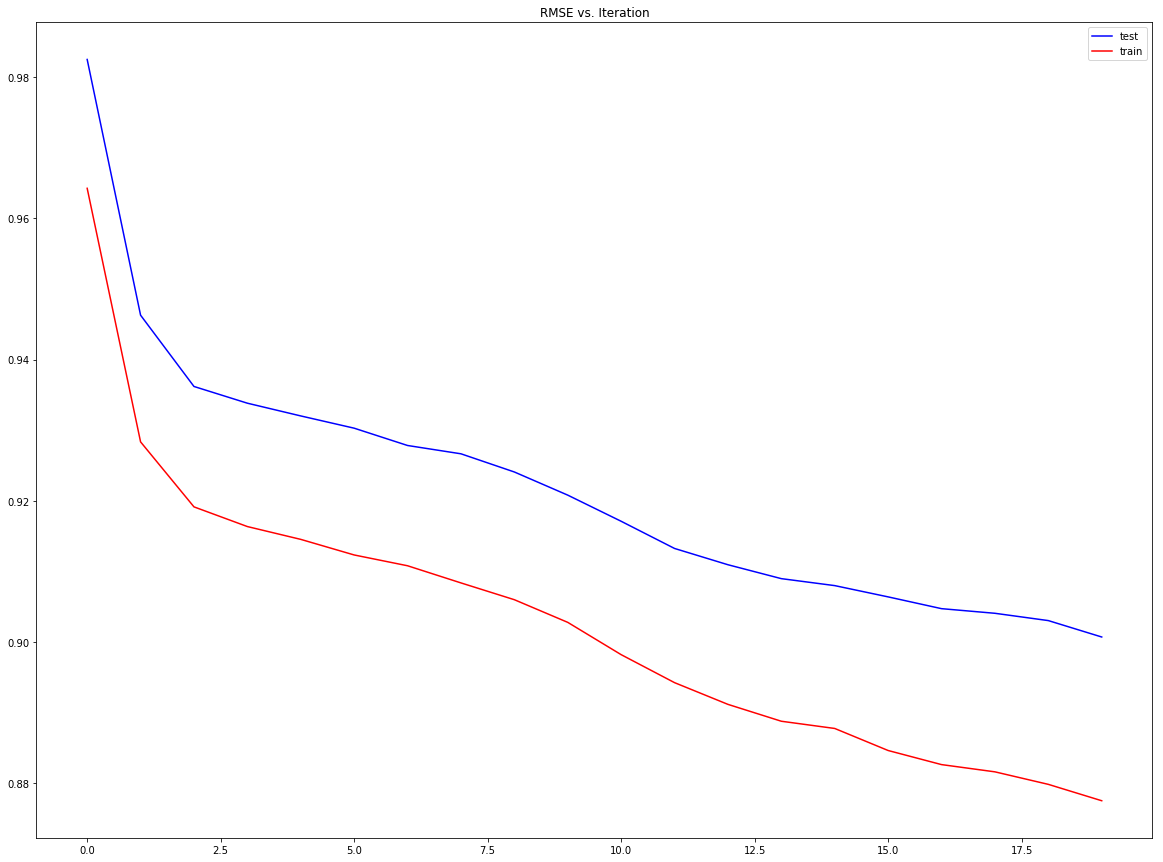

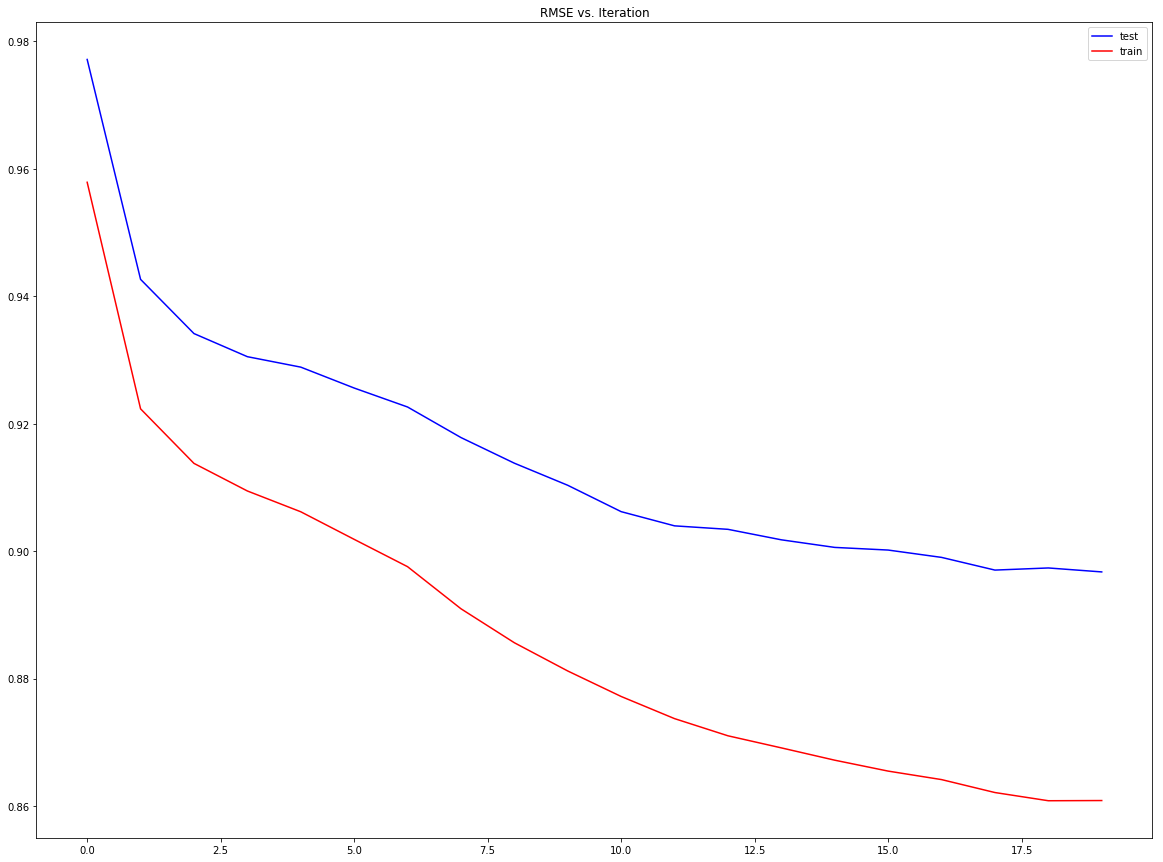

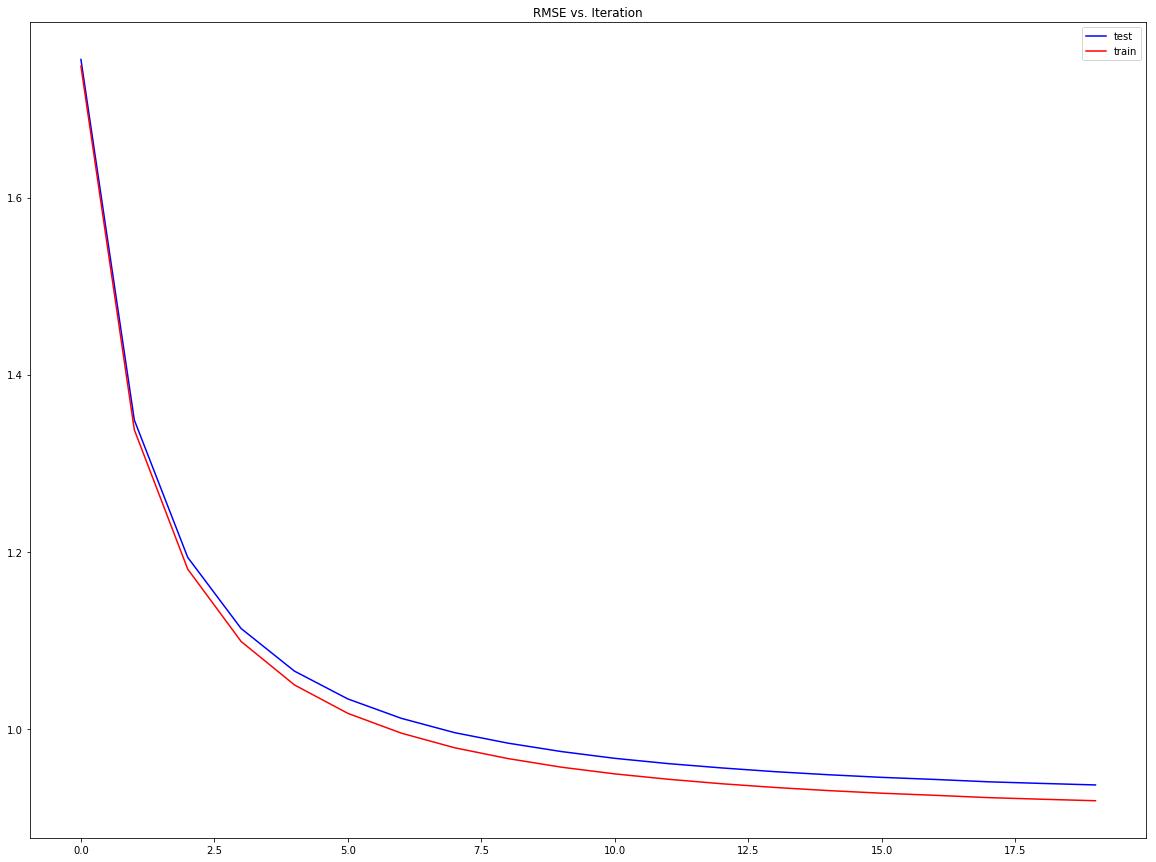

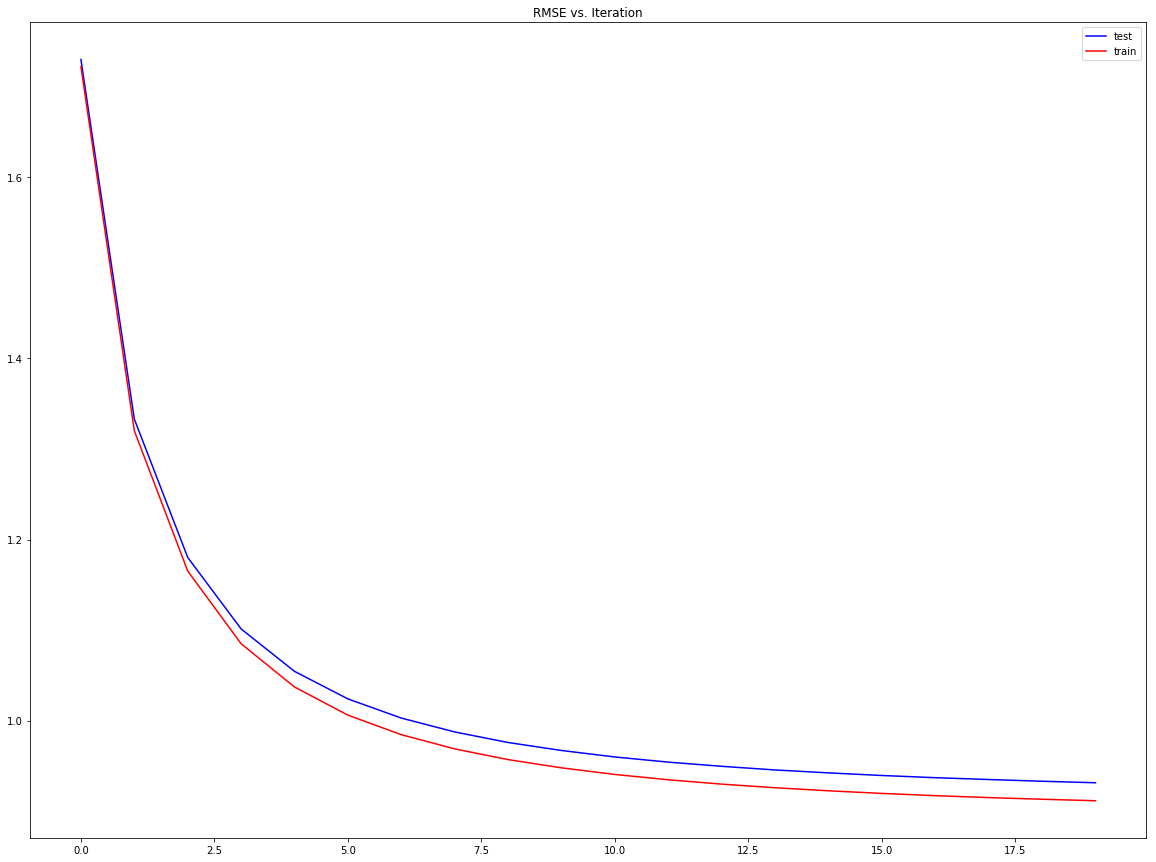

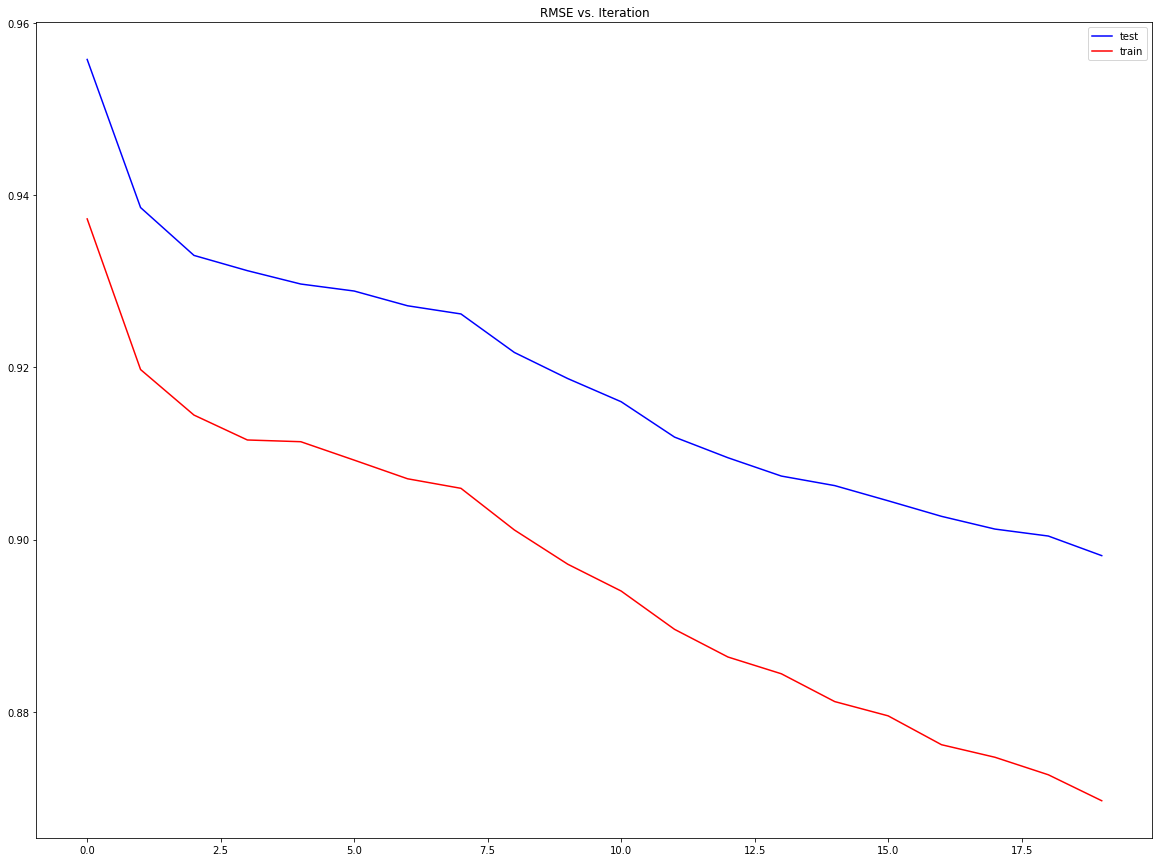

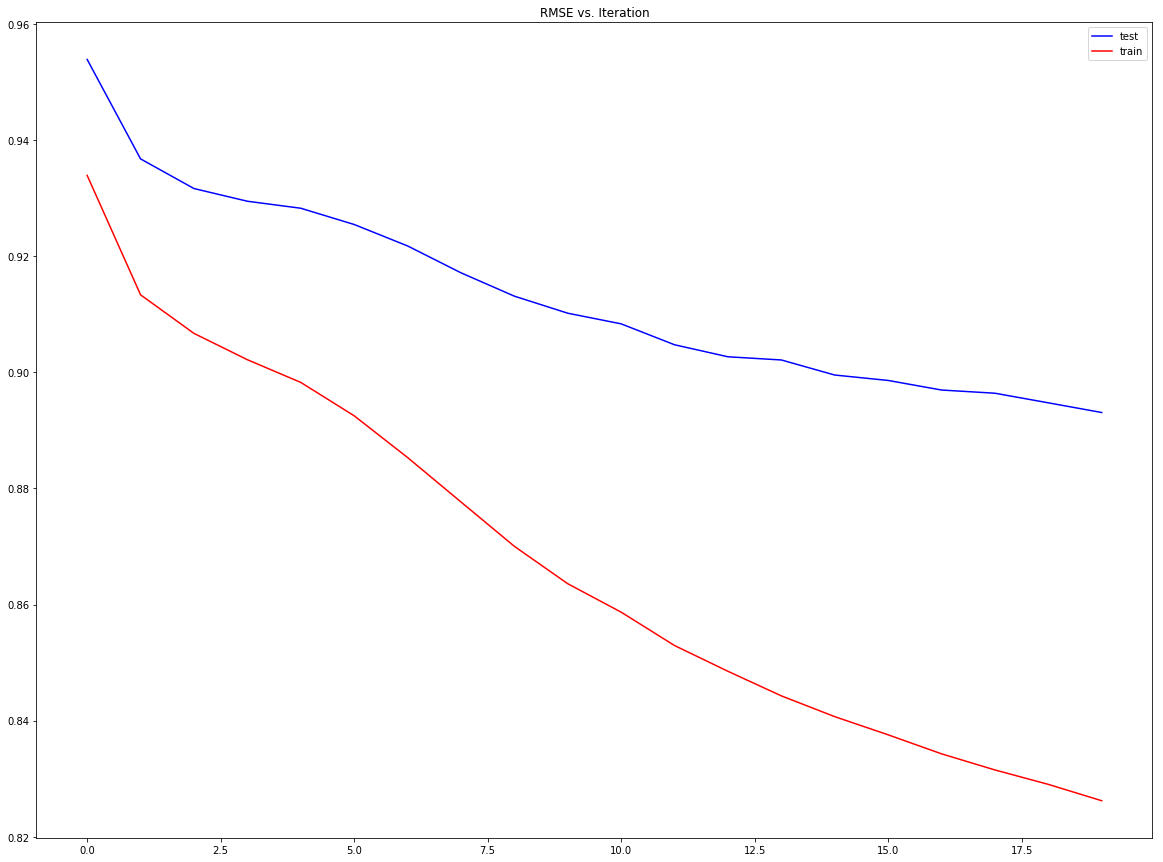

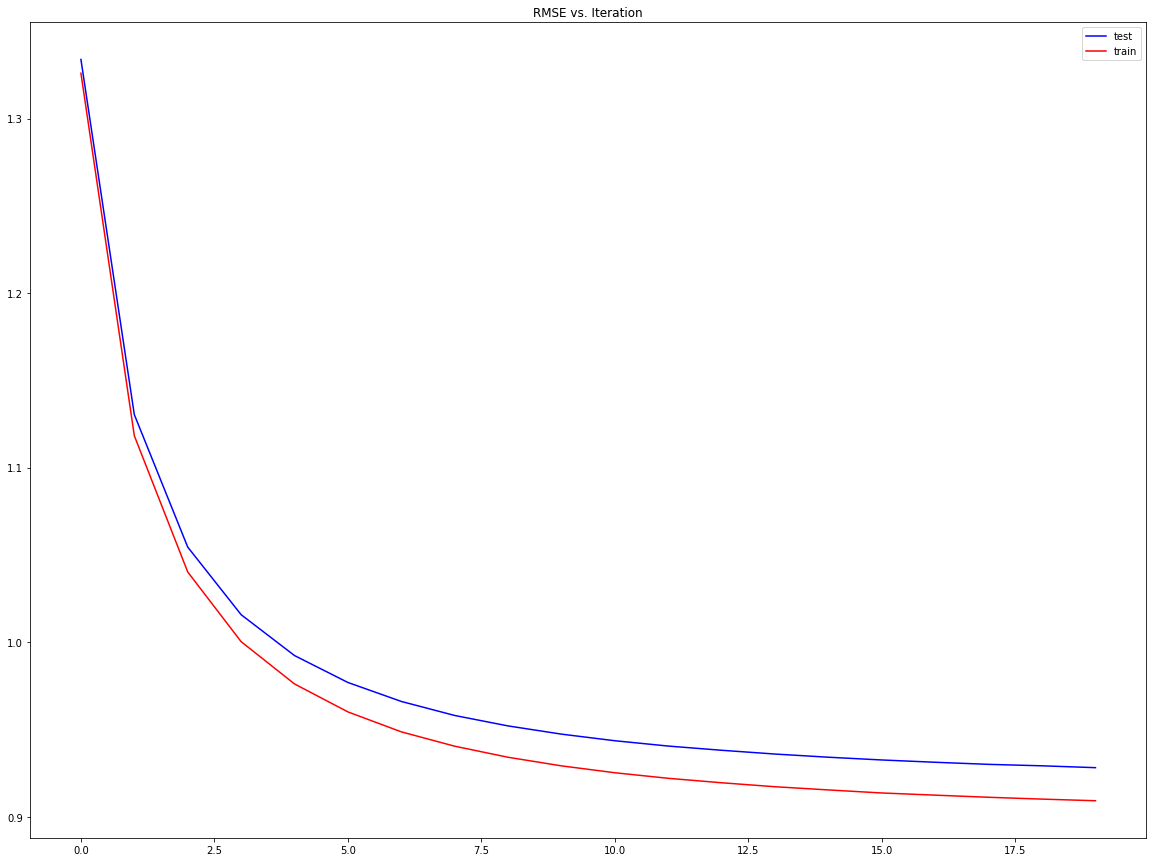

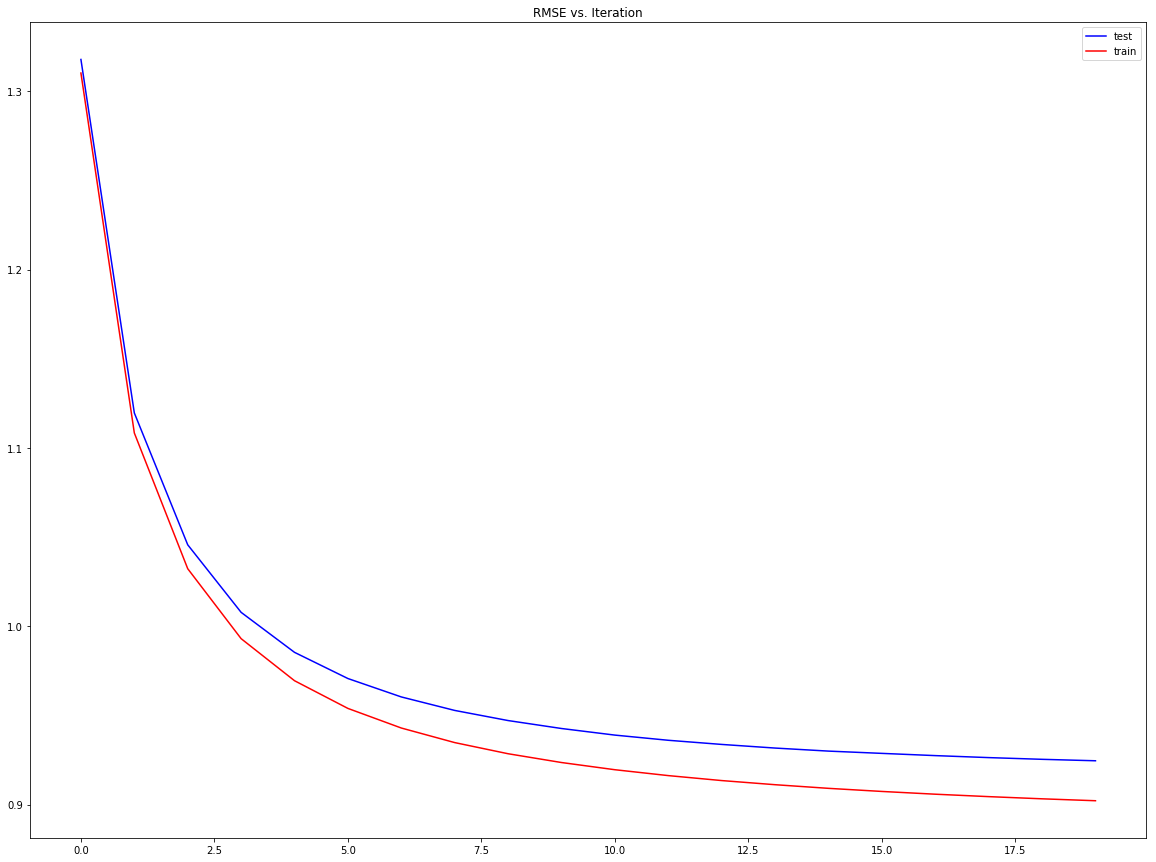

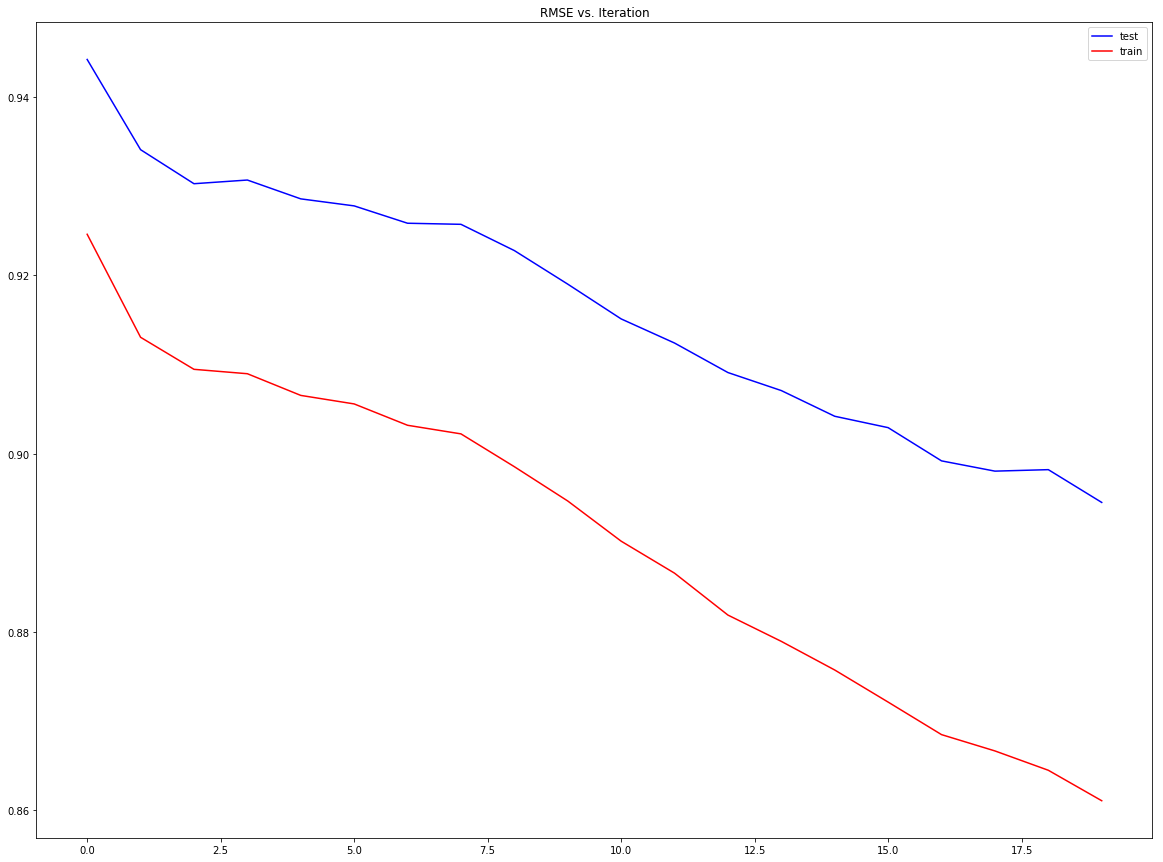

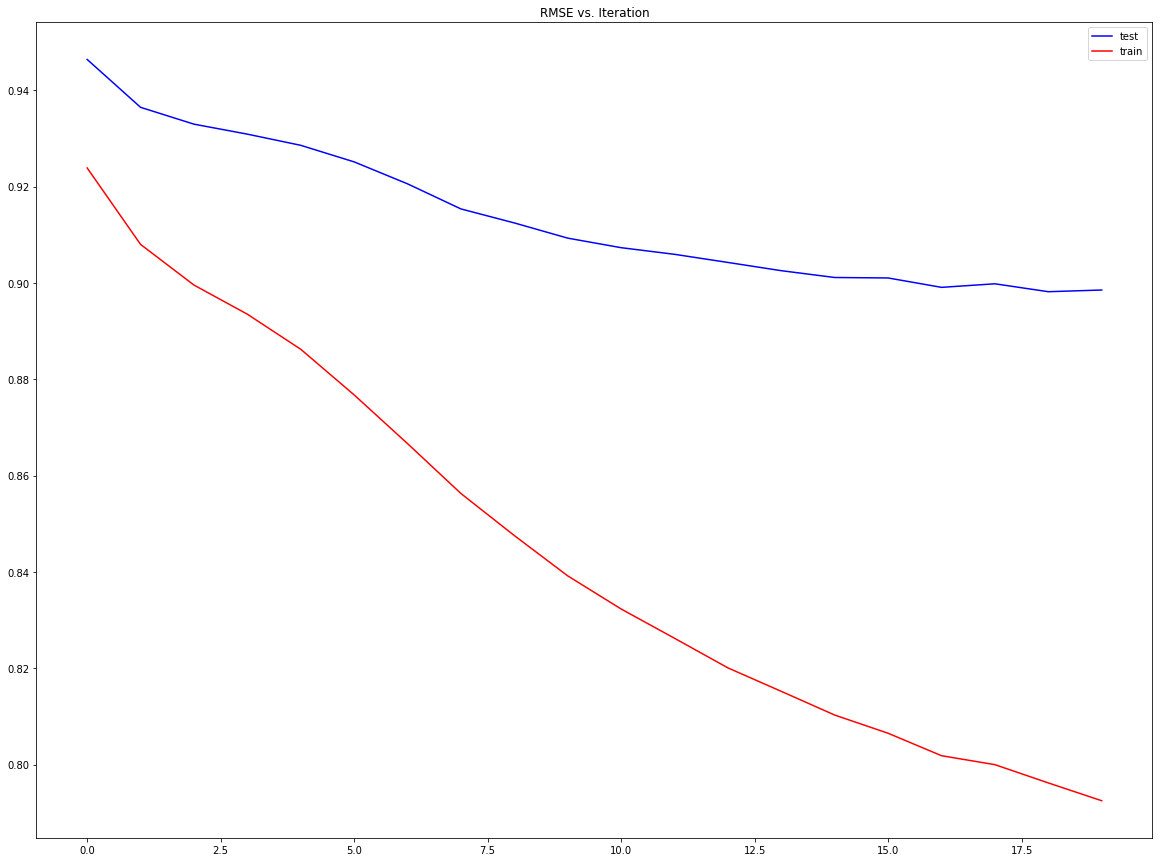

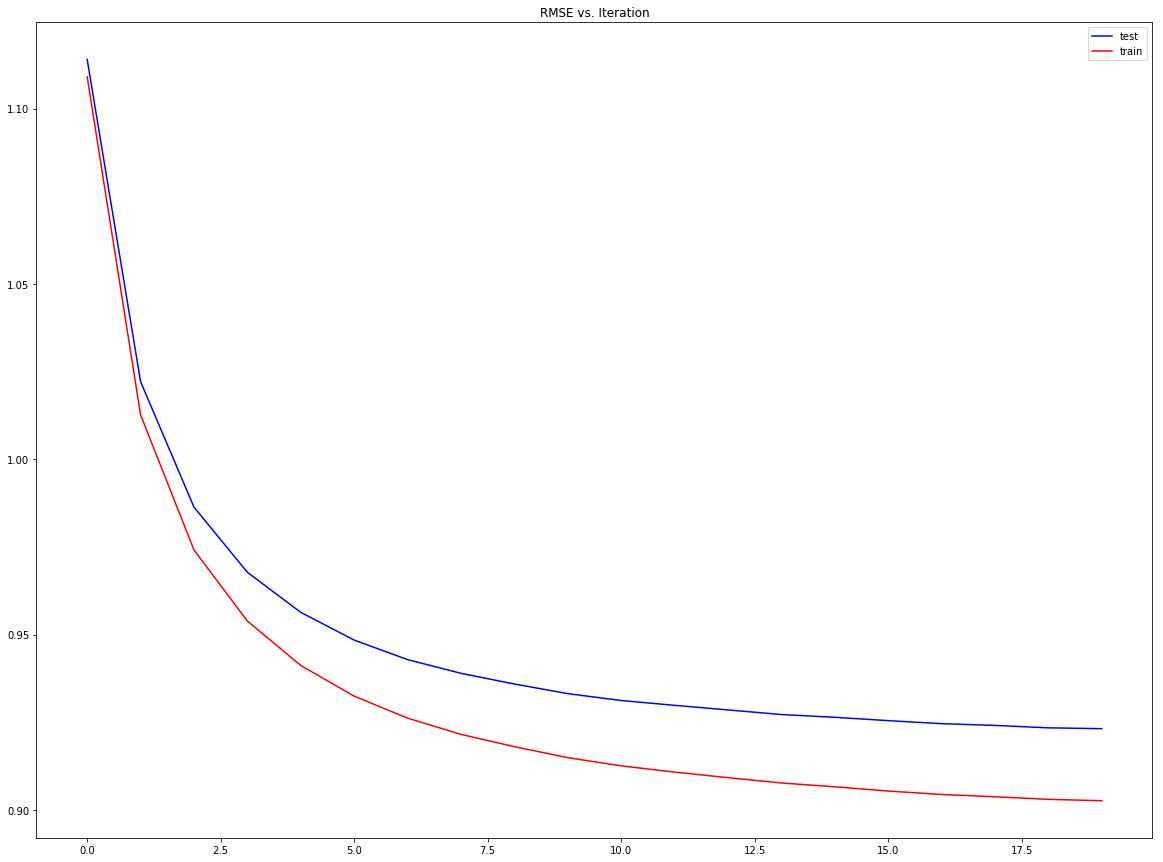

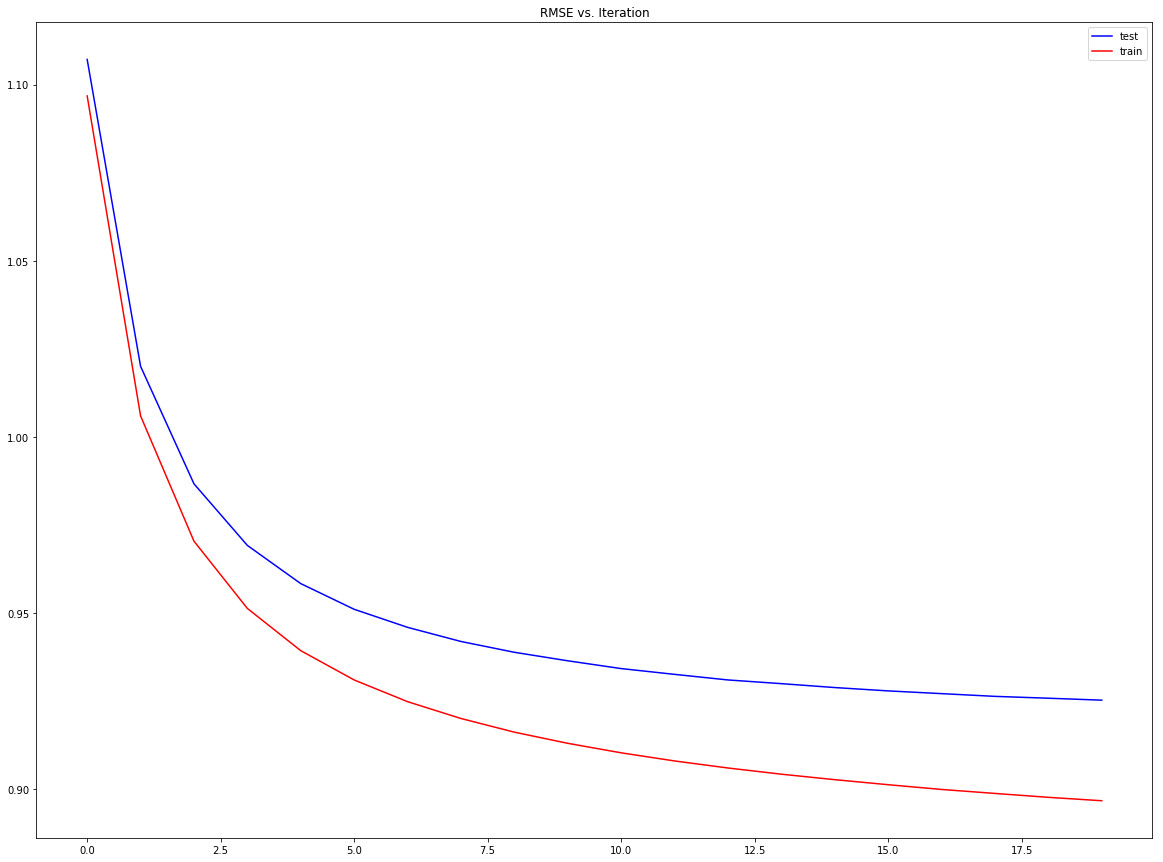

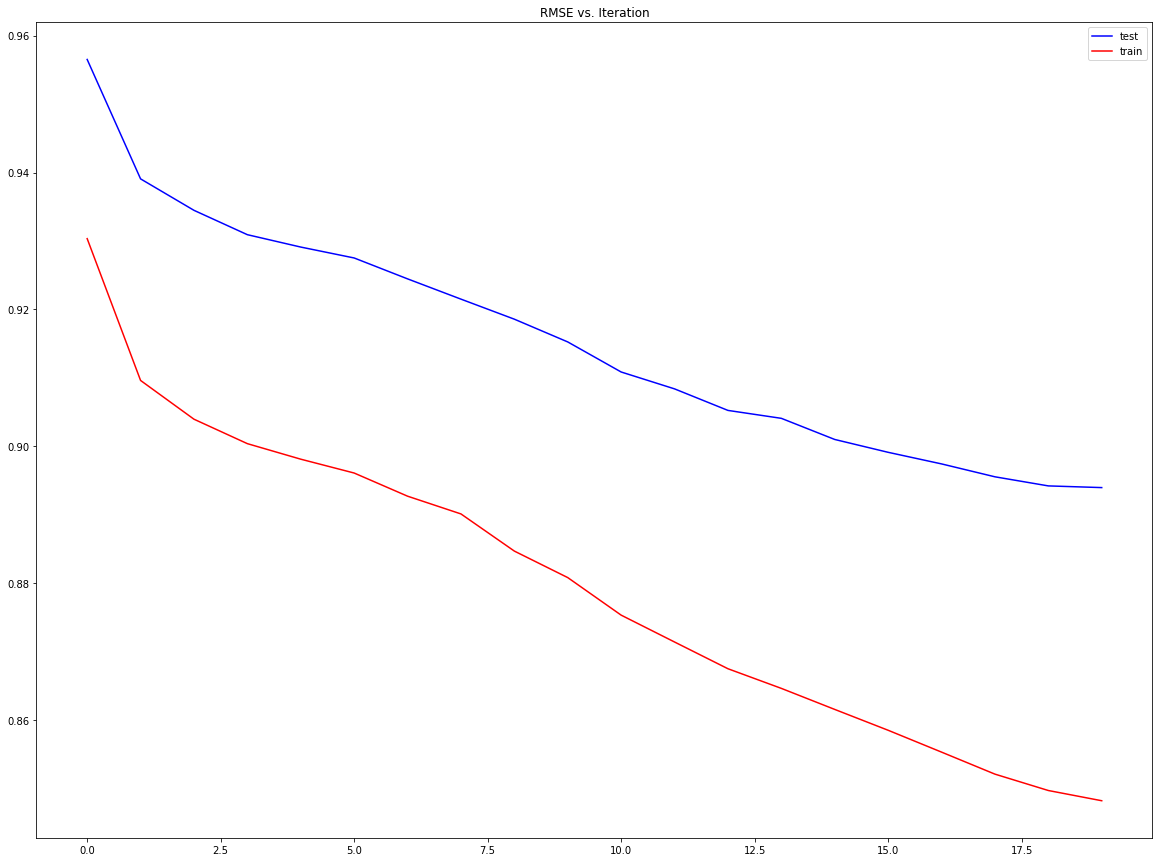

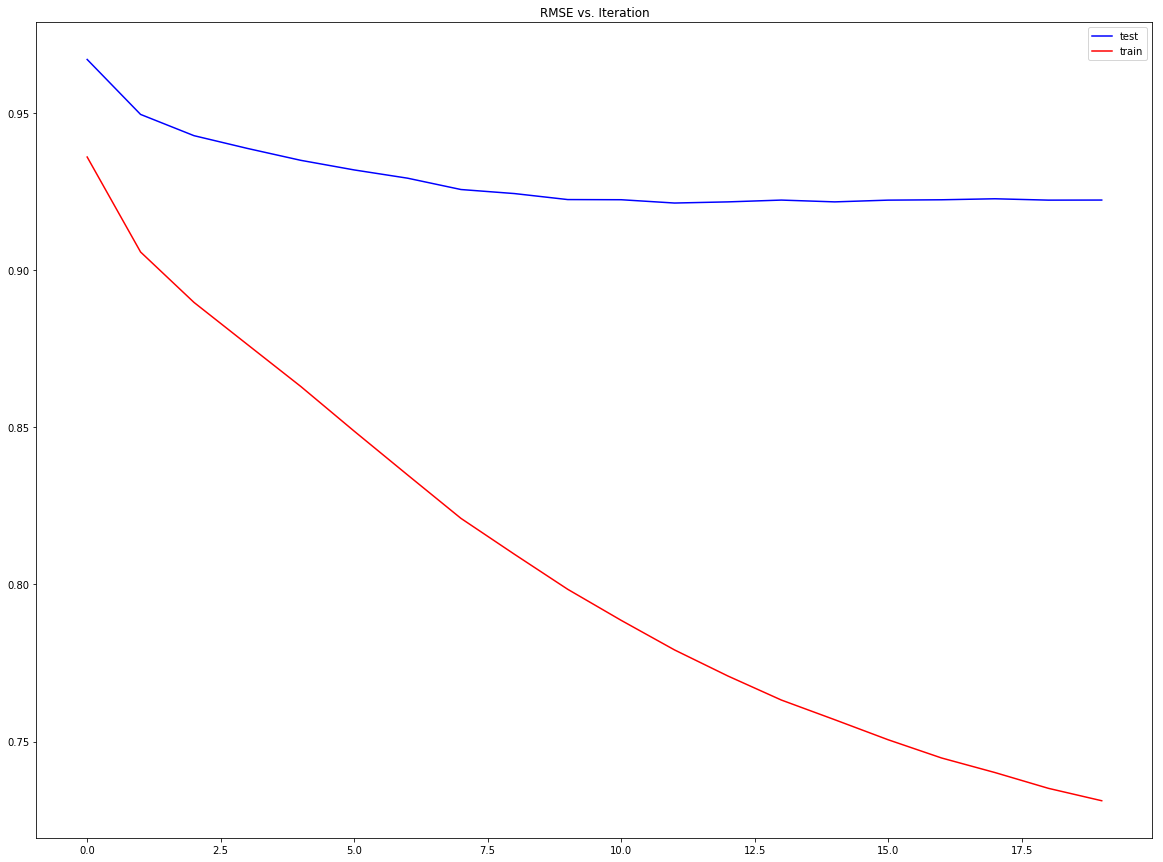

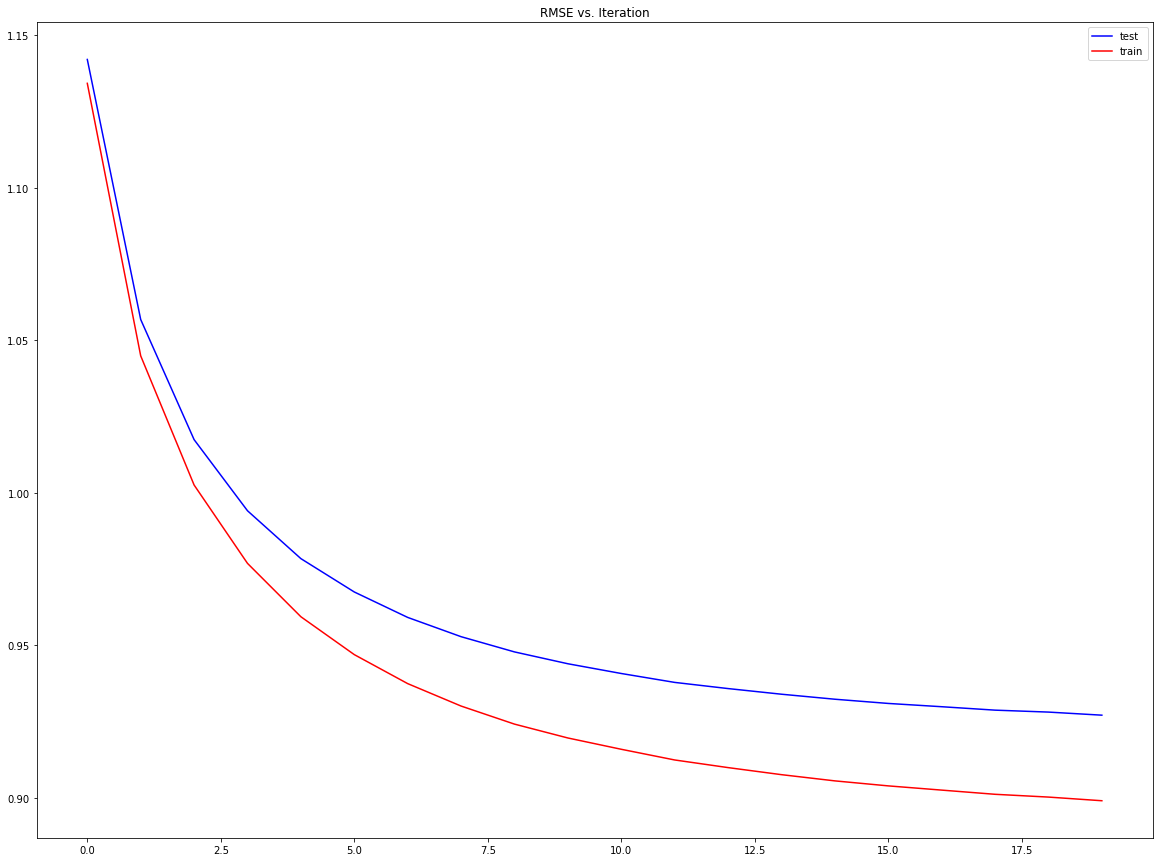

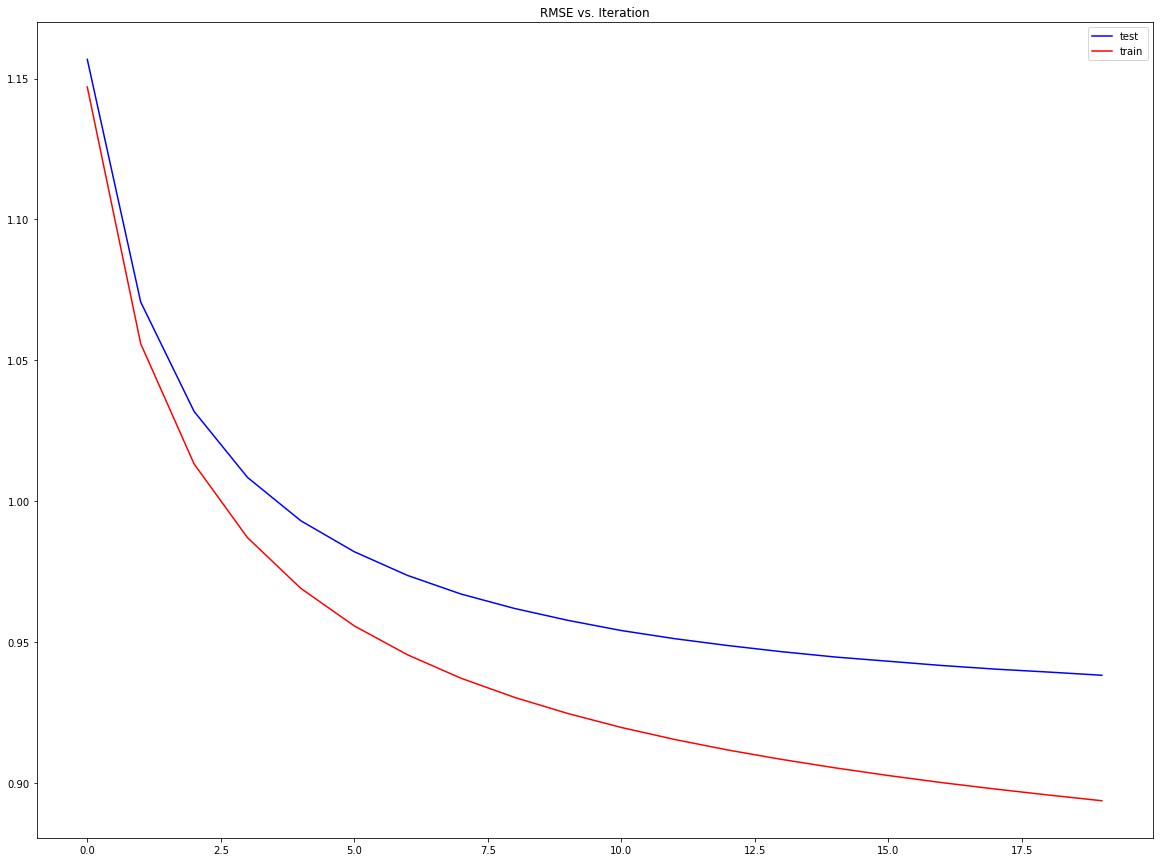

In [24]:
###Hyperparameter tunning
k_list = [3, 6, 10, 20] #latent features
alpha_list = [0.01, 0.001] #learning rate
lamb_list = [0.1, 0.01] #regularization penalty

rmse_train_list = []
rmse_test_list = []
hyperparameters_list = []

for K in k_list:
    for alpha in alpha_list:
        for lamb in lamb_list:
            print("Fitting for k =",K, "alpha =", alpha, "lambda =", lamb)
            rmse_train, rmse_test, p, q = SGA_MF(X_train, X_test, K, n_p, n_q, alpha, lamb, 20)
            rmse_train_list.append(rmse_train)
            rmse_test_list.append(rmse_test)
            hyperparameters_list.append((K, alpha, lamb))


In [28]:
DF = pd.DataFrame({'Hiperparemeters': hyperparameters_list,
                   'RMSE_train': rmse_train_list,
                   'RMSE_test': rmse_test_list})
DF

,Hiperparemeters,RMSE_test,RMSE_train
0,"(3, 0.01, 0.1)",0.900729,0.877554
1,"(3, 0.01, 0.01)",0.896752,0.860870
2,"(3, 0.001, 0.1)",0.936675,0.918846
3,"(3, 0.001, 0.01)",0.931284,0.911421
4,"(6, 0.01, 0.1)",0.898132,0.869674
5,"(6, 0.01, 0.01)",0.893075,0.826213
6,"(6, 0.001, 0.1)",0.928146,0.909204
7,"(6, 0.001, 0.01)",0.924566,0.902154
8,"(10, 0.01, 0.1)",0.894537,0.861088
9,"(10, 0.01, 0.01)",0.898534,0.792510


We notice that the best combination of hyperparameters is:

- K = 10
- Alpha =  0.01
- Lambda = 0.1

Since this hyperapameters set gives a low test RMSE and still the train RMSE is close (no overfitting) to that value. 

We try, however, with a higher value for lambda (lambda = 0.5) as follows.


Initial RMSE: 1.71006339999
Epoch: 0
RMSE test: 0.943988279754
Epoch: 5
RMSE test: 0.927705260354
Epoch: 10
RMSE test: 0.912887337492
Epoch: 15
RMSE test: 0.902251519165
Epoch: 20
RMSE test: 0.894062162292
Epoch: 25
RMSE test: 0.889240840548
Epoch: 30
RMSE test: 0.885770727114
Epoch: 35
RMSE test: 0.882442395013
Epoch: 40
RMSE test: 0.880776382115
Epoch: 45
RMSE test: 0.878777589519
Epoch: 50
RMSE test: 0.877484710431
Epoch: 55
RMSE test: 0.876715135192
Epoch: 60
RMSE test: 0.875682617606
Epoch: 65
RMSE test: 0.875225692678
Epoch: 70
RMSE test: 0.875288705883
Epoch: 75
RMSE test: 0.875233469328
Epoch: 80
RMSE test: 0.873458903529
Epoch: 85
RMSE test: 0.873852861983
Epoch: 90
RMSE test: 0.873430913014
Epoch: 95
RMSE test: 0.874136137546
Initial RMSE: 1.69727206857
Epoch: 0
RMSE test: 1.05627596556
Epoch: 5
RMSE test: 1.04933289364
Epoch: 10
RMSE test: 1.04537663289
Epoch: 15
RMSE test: 1.04921467587
Epoch: 20
RMSE test: 1.04718153126
Epoch: 25
RMSE test: 1.04635630608
Epoch: 30
RMSE tes

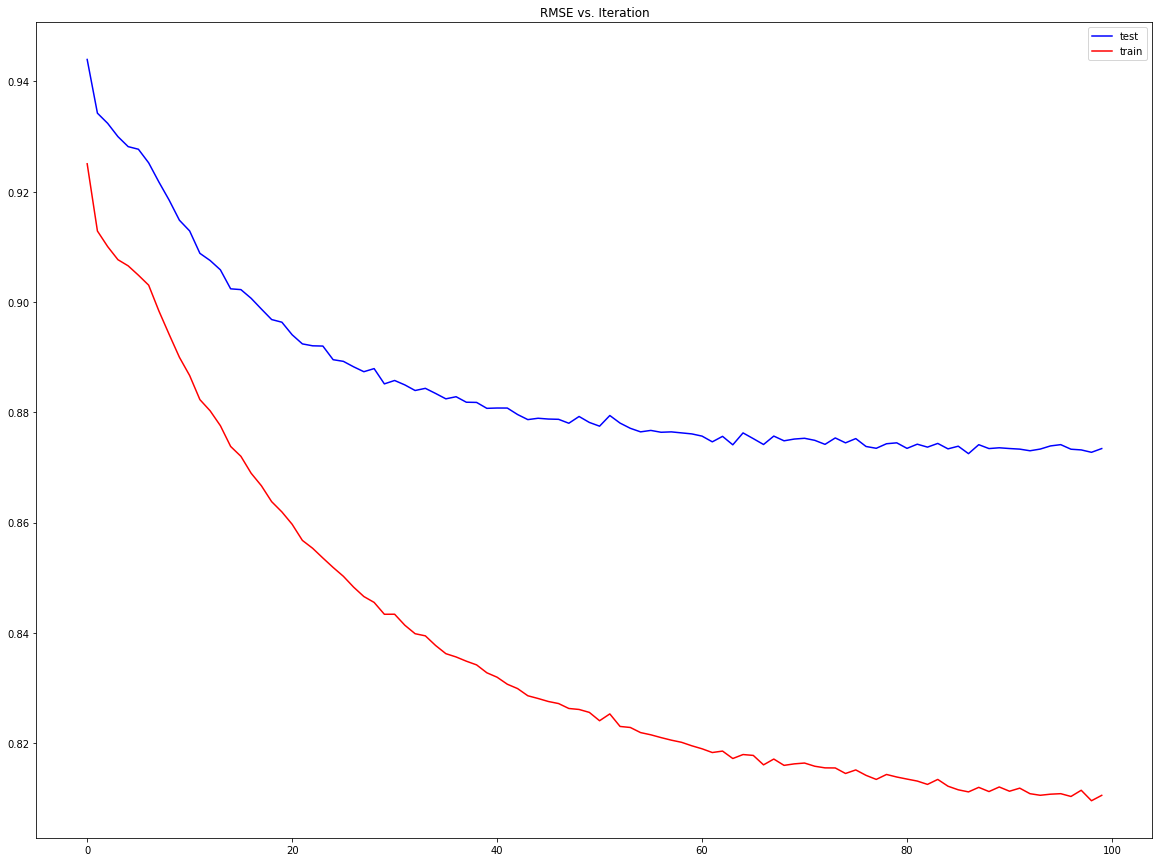

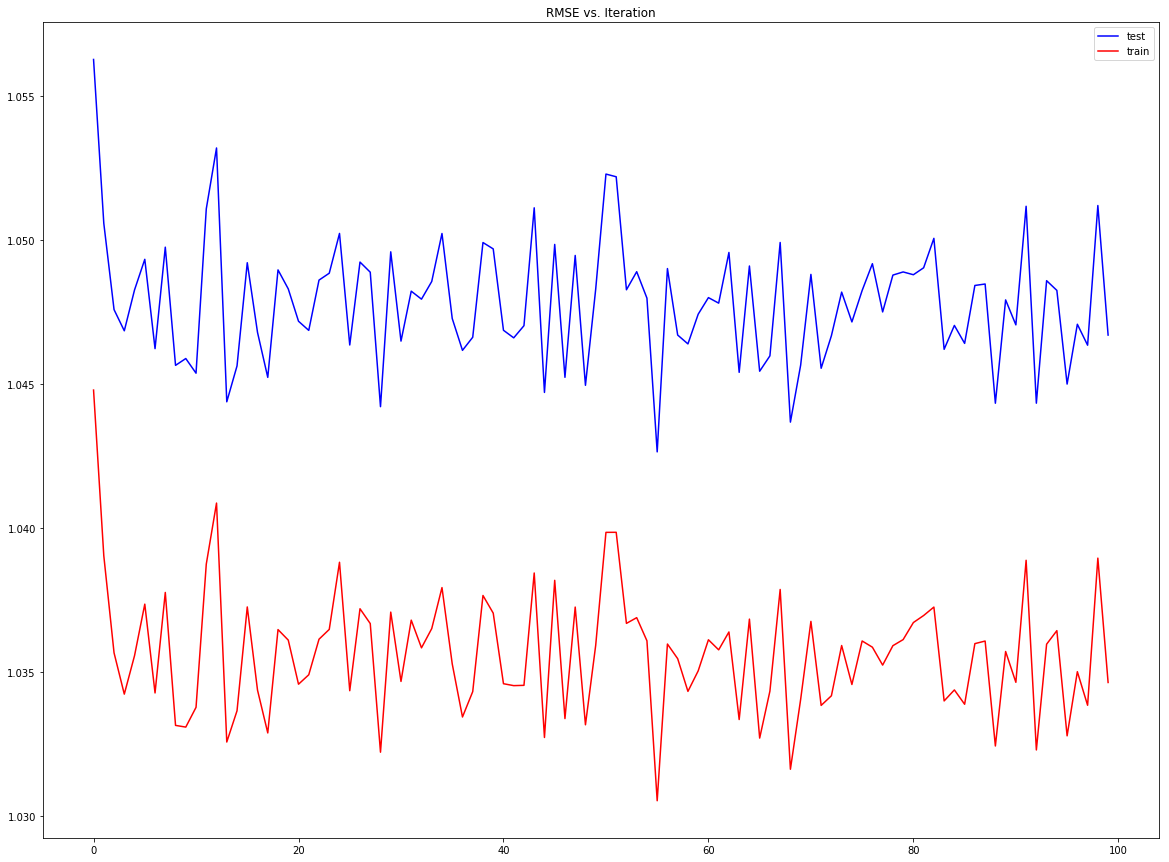

In [27]:
rmse_train1, rmse_test1, p1, q1 = SGA_MF(X_train, X_test, 10, n_p, n_q, 0.01, 0.1, 100) #lamb = 0.1
rmse_train2, rmse_test2, p2, q2 = SGA_MF(X_train, X_test, 10, n_p, n_q, 0.01, 0.5, 100) #lamb = 0.5

Yet the best choice is lambda = 0.1. We, therefore, train the last model with all the data. We also set maximum numer of iterations to 50 to avoid overfitting (early stopping), since on the graphs we see that, after this iteration, the improvement on test RMSE is low, but in train RMSE is still high. (Note that we made a dummy test set so that we can use the same function as before, therefore the final results on test are meaningless).


Initial RMSE: 2.63558971777
Epoch: 0
RMSE test: 3.07234302463
Epoch: 5
RMSE test: 3.18234849469
Epoch: 10
RMSE test: 3.31357190163
Epoch: 15
RMSE test: 3.16436276505
Epoch: 20
RMSE test: 3.19833260923
Epoch: 25
RMSE test: 3.06139886546
Epoch: 30
RMSE test: 3.00752298944
Epoch: 35
RMSE test: 2.99363550604
Epoch: 40
RMSE test: 2.96630523711
Epoch: 45
RMSE test: 2.96547318324


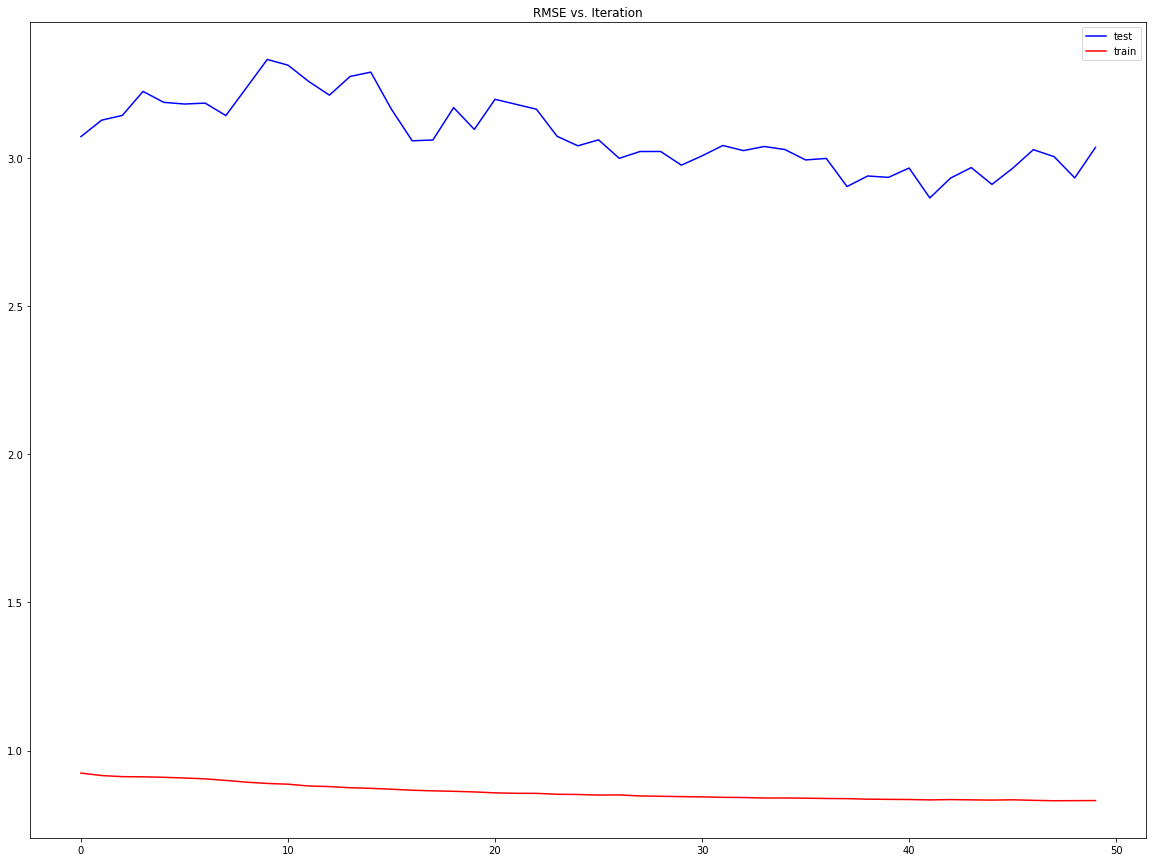

In [31]:
X_train = np.array(data)
X_test = np.array([[0,0,0]])
rmse_train, rmse_test, p, q = SGA_MF(X_train, X_test, 10, n_p, n_q, 0.01, 0.1, 50)

In [73]:
print("RMSE Train", rmse_train)

RMSE Train 0.831125428697


Now we have train the mode, we can make predictions. We define a new function to make these predictions and also apply the predictions to a new test set. The test set has only two columns (the user and item), since the goal is to predict the third column.

In [74]:
def predict(X):
    pred = np.zeros((X.shape[0],1))
    for idx, (u, i) in enumerate(zip(X[:,0], X[:,1])):
        pred [idx] = np.dot(p[u,:],q[i,:])
    return pred

test = pd.read_csv("test.data")

test.head()

,planet,person
0,4847,2282
1,795,2586
2,3721,2779
3,2771,2480
4,2825,2511


In [75]:
test.iloc[:,1] = test.iloc[:,1]-1 #since numeration starts in 1

test = np.array(test)
pred = predict(test)

In [76]:
print("Shape predictions:", pred.shape)
print("Max predictions:", max(pred))
print("Min predictions:", min(pred))
print("Max possible value:", max(data.iloc[:,2]))
print("Min possible value:", min(data.iloc[:,2]))

Shape predictions: (78235, 1)
Max predictions: [ 5.82292395]
Min predictions: [ 0.14754515]
Max possible value: 5
Min possible value: 1


Given the maximum and minimum values, we note that there are some values that are higher than the possible value (5) and lower thatn the lowest possible value (1). Therefore, we truncate values, so that every value lower than 1 gets truncated to 1 and every value greater than 5 gest truncated to 5.

In [77]:
pred[pred>5]=5
pred[pred<1]=1
print("Max predictions:", max(pred))
print("Min predictions:", min(pred))



Max predictions: [ 5.]
Min predictions: [ 1.]


In [78]:
##Saving results
with open('my_submission.txt', 'w') as f:
    for item in pred.round(6).T.tolist()[0]:
        f.write("%s\n" % item)

## References

[1] Source: data-artisans.com 

[2] Alternating least squares: https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/

[3] Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh _Matrix Completion and LowRank SVD via Fast Alternating Least Squares_ Statistics Department and ICME, Stanford University, 2014.

[4] Recommender systems (University Hildesheim): https://www.ismll.uni-hildesheim.de/lehre/ba-18w/script/6_recommender-systems.pdf